In [1]:
import numpy as np # xử lý mảng bên đại số tuyến tính
import pandas as pd 
import matplotlib.pyplot as plt #vẽ hình
import os
import h5py
import glob
import seaborn as sn
from PIL import Image
from pathlib import Path
from os import listdir, makedirs, getcwd, remove
from skimage.io import imread
from skimage.transform import resize
import keras
import imgaug.augmenters as iaa
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, SeparableConv2D, AveragePooling2D
from keras.layers import GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import cv2
from keras import backend as K
color = sn.color_palette()
print(os.listdir("../X-ray/input"))


Using TensorFlow backend.
C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\HP\Anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: Future

['chest_xray', 'VGG16']


In [ ]:
# khởi tạo các tham số ngẫu nhiên cho tensorflow và keras
import tensorflow as tf
# thiết lập seed cho những hoạt động dựa trên hàm băm ở python
os.environ['PYTHONHASHSEED'] = '0' 
# thiết lập hàm tạo tham số ngẫu nhiên để đối chiếu giữa các lần cập nhật tham số 
np.random.seed(111) 
# vô hiệu đa luồng trong tensorflow ops
session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
#thiết lập hàm tạo tham số ngẫu nhiên trong tensorflow tại mức đồ thị
tf.set_random_seed(111)
# xác định 1 phiên tensorflow với cấu hình phiên làm việc ở trên
sess = tf.Session(graph=tf.get_default_graph(), config=session_conf) 
# thiết lập phiên làm việc trong keras
K.set_session(sess)

#xác định chuỗi tăng cường (augmentation sequence)
#aug.seed(111)

In [2]:
#xác định đường dẫn đến thư mục dữ liệu 
#print(os.listdir(train_folder))
Data_main =Path( '../X-ray/input/chest_xray/chest_xray')
print(os.listdir(Data_main))
# đường dẫn đến thư mục train
train_dir = Data_main / 'train'

# đường dẫn đến thư mục val
val_dir = Data_main / 'val'

# đường dẫn đến thư mục test
test_dir = Data_main / 'test'
print(os.listdir(train_dir))

['.DS_Store', 'test', 'train', 'val']
['NORMAL', 'PNEUMONIA']


In [3]:
# lấy đường dẫn đến thư mục con normal and pneumonia của thư mục train
train_n = train_dir / 'NORMAL'
train_p = train_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_cases = train_n.glob('*.jpeg')
pneumonia_cases = train_p.glob('*.jpeg')

In [7]:
#chuẩn bị dữ liệu training
train_n = train_dir / 'NORMAL'
train_p = train_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_cases = train_n.glob('*.jpeg')
pneumonia_cases = train_p.glob('*.jpeg')
# thử liệt kê các ảnh trong 2 thư mục normal và pneumonia của thư mục train bằng cách chèn dữ liệu của 2 thư mục này vào trong một list trống

t_data=[]
# ta gán tất cả ảnh trong normal_cases với nhãn là 0
for img in normal_cases:
    t_data.append((img,0))
    
# gán tất cả ảnh trong pneumonia_cases với nhãn là 1
for img in pneumonia_cases:
    t_data.append((img,1))
# cho dữ liệu mà ta có trong danh sách vào 1 pandas dataframe
t_data = pd.DataFrame(t_data, columns=['image', 'label'],index=None)
# trộn dữ liệu
t_data = t_data.sample(frac=1.).reset_index(drop=True)
t_data.head(len(t_data))
#print(t_data)

,image,label
0,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
1,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
2,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
3,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
4,..\X-ray\input\chest_xray\chest_xray\train\NOR...,0
...,...,...
5211,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
5212,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
5213,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1
5214,..\X-ray\input\chest_xray\chest_xray\train\PNE...,1


1    3875
0    1341
Name: label, dtype: int64


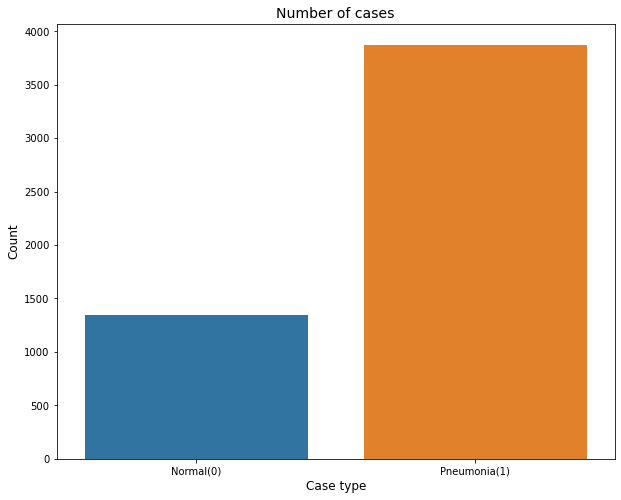

In [8]:
# lấy số lượng ảnh của mỗi label
cases_count = t_data['label'].value_counts()
print(cases_count)

# vẽ biểu đồ biểu thị tương quan về số lượng mỗi nhãn  
plt.figure(figsize=(10,8))
sn.barplot(x=cases_count.index, y= cases_count.values)
plt.title('Number of cases', fontsize=14)
plt.xlabel('Case type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(range(len(cases_count.index)), ['Normal(0)', 'Pneumonia(1)'])
plt.show()

1341
normal picture title:  IM-0472-0001.jpeg
3875
pneumonia picture title: person1582_bacteria_4143.jpeg


Text(0.5, 1.0, 'Pneumonia')

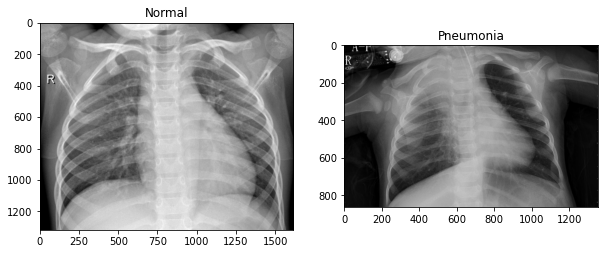

In [7]:
#xem một vài ảnh từ 2 thư mục normal và pneumonia trong train folder
train_dir= '../X-ray/input/chest_xray/chest_xray/train/'
val_dir = '../X-ray/input/chest_xray/chest_xray/val/'
test_dir = '../X-ray/input/chest_xray/chest_xray/test/'

train_n = train_dir + 'NORMAL/'
train_p = train_dir + 'PNEUMONIA/'

#Normal pic 
print(len(os.listdir(train_n)))
rand_norm= np.random.randint(0,len(os.listdir(train_n)))
norm_pic = os.listdir(train_n)[rand_norm]
norm_pic_address = train_n+norm_pic
print('normal picture title: ',norm_pic)

#Pneumonia pic
print(len(os.listdir(train_p)))
rand_p = np.random.randint(0,len(os.listdir(train_p)))
sic_pic =  os.listdir(train_p)[rand_p]
sic_address = train_p+sic_pic
print('pneumonia picture title:', sic_pic)

# Load the images
norm_load = Image.open(norm_pic_address)
sic_load = Image.open(sic_address)

#hiển thị ảnh 
f = plt.figure(figsize= (10,6))
a1 = f.add_subplot(1,2,1)
img_plot = plt.imshow(norm_load, cmap = 'gray')
a1.set_title('Normal')

a2 = f.add_subplot(1, 2, 2)
img_plot = plt.imshow(sic_load, cmap = 'gray')
a2.set_title('Pneumonia')

In [9]:
## Augmentation sequence 
#seq = iaa.OneOf([
#    iaa.Fliplr(), # lật ngang
#    iaa.Affine(rotate=15), # xoay ảnh
#    iaa.Multiply((1.2, 1.5))]) #độ sáng ngẫu nhiên 
#chuẩn bị dữ liệu training
train_dir = Data_main / 'train'

train_n = train_dir / 'NORMAL'
train_p = train_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_cases = train_n.glob('*.jpeg')
pneumonia_cases = train_p.glob('*.jpeg')

train_data = []
train_labels = []
 
#chuẩn hóa giá trị pixel ảnh và resize tất cả ảnh tới kích thước 64x64

# Normal cases, tăng gấp đôi số lượng ảnh trong mục normal_cases để số ảnh không bị bệnh ngang ngửa số ảnh bị bệnh
for img in normal_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    train_data.append(img)
    train_labels.append(label)
    '''aug_img1 = seq.augment_image(img)
    aug_img2 = seq.augment_image(img)
    aug_img1 = cv2.cvtColor(aug_img1, cv2.COLOR_BGR2RGB) # đọc trong chế độ ảnh màu 
    aug_img2 = cv2.cvtColor(aug_img2, cv2.COLOR_BGR2RGB)
    aug_img1 = aug_img1.astype(np.float32)/255. #chuẩn hóa pixel ảnh 
    aug_img2 = aug_img2.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    train_data.append(aug_img1)
    train_labels.append(label)
    train_data.append(aug_img2)
    train_labels.append(label)'''
                      
# Pneumonia cases        
for img in pneumonia_cases:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    train_data.append(img)
    train_labels.append(label)
    
# chuyển list thành mảng numpy để xử lý tensor
train_data = np.array(train_data)
train_labels = np.array(train_labels)
print(train_data.shape)
print(train_labels)

(5216, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [8]:
(trainX, testX, trainY, testY) = train_test_split(train_data, train_labels,
    test_size=0.20, stratify=train_labels, random_state=42)
trainaug = ImageDataGenerator(rotation_range = 15,
                              width_shift_range = 0.1, height_shift_range = 0.1, shear_range = 0.1,
                              zoom_range = 0.1,fill_mode = "nearest")
testaug = ImageDataGenerator(rotation_range = 15, fill_mode = "nearest")

In [9]:
baseModel = VGG16(weights="imagenet", include_top=False,
    input_tensor = Input(shape = (224,224,3)))
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size = (3,3))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation = "relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [54]:
for i, layer in enumerate(model.layers):
    print("{}:{}".format(i, layer))

0:<keras.engine.input_layer.InputLayer object at 0x00000223B6F57080>
1:<keras.layers.convolutional.Conv2D object at 0x00000223B6F57198>
2:<keras.layers.convolutional.Conv2D object at 0x00000223B6F57668>
3:<keras.layers.pooling.MaxPooling2D object at 0x00000223B6F57358>
4:<keras.layers.convolutional.Conv2D object at 0x00000223B6F57B00>
5:<keras.layers.convolutional.Conv2D object at 0x00000223B6F5EE48>
6:<keras.layers.pooling.MaxPooling2D object at 0x00000223B6F5ECC0>
7:<keras.layers.convolutional.Conv2D object at 0x00000223B6F5ED68>
8:<keras.layers.convolutional.Conv2D object at 0x00000223B6F75E48>
9:<keras.layers.convolutional.Conv2D object at 0x00000223B6F7BD30>
10:<keras.layers.pooling.MaxPooling2D object at 0x00000223B6F7B9B0>
11:<keras.layers.convolutional.Conv2D object at 0x00000223B6F80CF8>
12:<keras.layers.convolutional.Conv2D object at 0x00000223B6F8CDA0>
13:<keras.layers.convolutional.Conv2D object at 0x00000223B6F8CC88>
14:<keras.layers.pooling.MaxPooling2D object at 0x000002

In [27]:
# mở file weight từ pre-trained của VGG16
f = h5py.File('../X-ray/input/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# chọn layer mà bạn muốn gán weights

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [91]:
#es = EarlyStopping(patience = 5)
ch = ModelCheckpoint(filepath = "file_model_h9", monitor = 'val_loss', verbose = 1, save_weights_only = False,
                            save_best_only = True, mode = 'min')

In [12]:
''''for layer in baseModel.layers[:7]:
    layer.trainable = False
for layer in baseModel.layers[7:]:
    layer.trainable = True'''
for layer in baseModel.layers:
    layer.trainable = False
epochs = 10
opt = Adam(lr = 1e-4, decay = 1e-4/epochs)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])
H = model.fit_generator(
                        trainaug.flow(trainX, trainY, batch_size = 8), 
                        steps_per_epoch = len(trainX)//8,
                        validation_data = (testaug.flow(testX, testY, batch_size = 8)),
                        validation_steps = len(testX)//8,
                        callbacks = [ch],
                        epochs = 10)

Epoch 1/10
521/521 [==============================] - 272s 521ms/step - loss: 0.3845 - accuracy: 0.8208 - val_loss: 0.4114 - val_accuracy: 0.9260

Epoch 00001: val_accuracy improved from -inf to 0.92596, saving model to file_model_h7
Epoch 2/10
521/521 [==============================] - 238s 457ms/step - loss: 0.2300 - accuracy: 0.9097 - val_loss: 0.7735 - val_accuracy: 0.9228

Epoch 00002: val_accuracy did not improve from 0.92596
Epoch 3/10
521/521 [==============================] - 236s 452ms/step - loss: 0.1978 - accuracy: 0.9210 - val_loss: 0.0558 - val_accuracy: 0.9556

Epoch 00003: val_accuracy improved from 0.92596 to 0.95560, saving model to file_model_h7
Epoch 4/10
521/521 [==============================] - 236s 452ms/step - loss: 0.1822 - accuracy: 0.9299 - val_loss: 0.5976 - val_accuracy: 0.9315

Epoch 00004: val_accuracy did not improve from 0.95560
Epoch 5/10
521/521 [==============================] - 236s 452ms/step - loss: 0.1798 - accuracy: 0.9311 - val_loss: 0.5887 - 

In [13]:
for layer in baseModel.layers[15:]:
    layer.trainable = True
epochs = 20
opt = Adam(lr = 1e-4, decay = 1e-4/epochs)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])
H = model.fit_generator(
                        trainaug.flow(trainX, trainY, batch_size = 8), 
                        steps_per_epoch = len(trainX)//8,
                        validation_data = (testaug.flow(testX, testY, batch_size = 8)),
                        validation_steps = len(testX)//8,
                        callbacks = [ch],
                        epochs = 20)

Epoch 1/20
521/521 [==============================] - 281s 540ms/step - loss: 0.1632 - accuracy: 0.9397 - val_loss: 0.5448 - val_accuracy: 0.9625

Epoch 00001: val_accuracy did not improve from 0.96911
Epoch 2/20
521/521 [==============================] - 283s 542ms/step - loss: 0.1113 - accuracy: 0.9623 - val_loss: 0.0370 - val_accuracy: 0.9710

Epoch 00002: val_accuracy improved from 0.96911 to 0.97104, saving model to file_model_h7
Epoch 3/20
521/521 [==============================] - 280s 538ms/step - loss: 0.0944 - accuracy: 0.9659 - val_loss: 0.0033 - val_accuracy: 0.9836

Epoch 00003: val_accuracy improved from 0.97104 to 0.98359, saving model to file_model_h7
Epoch 4/20
521/521 [==============================] - 281s 538ms/step - loss: 0.0795 - accuracy: 0.9738 - val_loss: 0.0335 - val_accuracy: 0.9720

Epoch 00004: val_accuracy did not improve from 0.98359
Epoch 5/20
521/521 [==============================] - 282s 542ms/step - loss: 0.0735 - accuracy: 0.9765 - val_loss: 0.0226

In [ ]:
for layer in baseModel.layers[15:]:
    layer.trainable = True
epochs = 10
opt = Adam(lr = 1e-4, decay = 1e-4/epochs)
model.compile(optimizer = opt, loss = "binary_crossentropy", metrics = ["accuracy"])
H = model.fit_generator(
                        trainaug.flow(trainX, trainY, batch_size = 8), 
                        steps_per_epoch = len(trainX)//8,
                        validation_data = (testaug.flow(testX, testY, batch_size = 8)),
                        validation_steps = len(testX)//8,
                        callbacks = [ch],
                        epochs = 10)

In [ ]:
model.save('../X-ray_2/model_hien')

In [ ]:
# mở file weight từ pre-trained của VGG16
f = h5py.File('../X-ray/input/VGG16/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 'r')

# chọn layer mà bạn muốn gán weights

w,b = f['block1_conv1']['block1_conv1_W_1:0'], f['block1_conv1']['block1_conv1_b_1:0']
model.layers[1].set_weights = [w,b]

w,b = f['block1_conv2']['block1_conv2_W_1:0'], f['block1_conv2']['block1_conv2_b_1:0']
model.layers[2].set_weights = [w,b]

w,b = f['block2_conv1']['block2_conv1_W_1:0'], f['block2_conv1']['block2_conv1_b_1:0']
model.layers[4].set_weights = [w,b]

w,b = f['block2_conv2']['block2_conv2_W_1:0'], f['block2_conv2']['block2_conv2_b_1:0']
model.layers[5].set_weights = [w,b]

f.close()
#for layer in model.layers[:6]:
 #   layer.trainable=False
#for layer in model.layers[6:]:
 #   layer.trainable=True
model.summary()

In [29]:
epochs = 30
init_lr = 1e-4
opt = Adam(lr = init_lr, decay = init_lr/epochs)
#validation_data=(valid_data, valid_labels),callbacks=[es, ch], class_weight = {0:1.0, 1:0.7}
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])

In [28]:
# biên dịch mô hình, chỉ rõ hàm loss_function nào được sử dụng, phương thức dùng để tối ưu hàm loss function.
model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
#batch_size=16 #Là size trong mini-batch gradient descent, nghĩa là dùng bao nhiêu dữ liệu cho mỗi lần tính và cập nhật hệ số
#steps_per_epoch = len(t_data)//batch_size # số lần thực hiện bước 2 trong gradient descent trong mỗi epoch
es = EarlyStopping(patience=5) # dung train neu tham so quan sat khong kha len sau 5 epochs
ch = ModelCheckpoint(filepath='file_weight_model_3', save_best_only=True, save_weights_only=True) # lưu file weight

In [ ]:
# Thực hiện huấn luyện mô hình với data
H = model.fit(train_data, train_labels, validation_data = (testX, testY), batch_size = 8, epochs = 20,
            callbacks=[es, ch], class_weight = {0:1.0, 1:0.7}, verbose = 1)

In [81]:
for i,layer in enumerate(model.layers):
  print("{}: {}".format(i,layer))

0: <keras.engine.input_layer.InputLayer object at 0x000001A387D22470>
1: <keras.layers.convolutional.Conv2D object at 0x000001A387D22A20>
2: <keras.layers.convolutional.Conv2D object at 0x000001A387D22EF0>
3: <keras.layers.pooling.MaxPooling2D object at 0x000001A3C55F26A0>
4: <keras.layers.convolutional.Conv2D object at 0x000001A3C55F2400>
5: <keras.layers.convolutional.Conv2D object at 0x000001A3C55F9F98>
6: <keras.layers.pooling.MaxPooling2D object at 0x000001A3C55F9D68>
7: <keras.layers.convolutional.Conv2D object at 0x000001A3C55F9C88>
8: <keras.layers.convolutional.Conv2D object at 0x000001A3C5603CC0>
9: <keras.layers.convolutional.Conv2D object at 0x000001A3C5612D30>
10: <keras.layers.pooling.MaxPooling2D object at 0x000001A3C56127B8>
11: <keras.layers.convolutional.Conv2D object at 0x000001A3C561BDA0>
12: <keras.layers.convolutional.Conv2D object at 0x000001A3C5626E80>
13: <keras.layers.convolutional.Conv2D object at 0x000001A3C5626F98>
14: <keras.layers.pooling.MaxPooling2D obj

In [ ]:
epochs = 10
init_lr = 1e-3
opt = Adam(lr = init_lr, decay = init_lr/epochs)
model.compile(opt, 'categorical_crossentropy', ['accuracy'])
es = EarlyStopping(patience=5) # dung train neu tham so quan sat khong kha len sau 5 epochs
ch = ModelCheckpoint(filepath='file_weight_model_3', save_best_only=True, save_weights_only=True) # lưu file weight
H = model.fit(train_data, train_labels, validation_data = (testX, testY), batch_size = 16, epochs = 10,
            callbacks = [es,ch], class_weight = {0:1.0, 1:0.7}, verbose = 1)

In [ ]:
# tải file weight đã được lưu sau khi huấn luyện xong mô hình nếu bạn không muốn chạy qua bước huấn luyện mất 
# thời gian chừng 60 phút 
model.load_weights("../X-ray_2/file_weight_model_3")


In [100]:
model_h7 = keras.models.load_model("file_model_h7")

In [8]:
model_h8 = keras.models.load_model("file_model_h7")

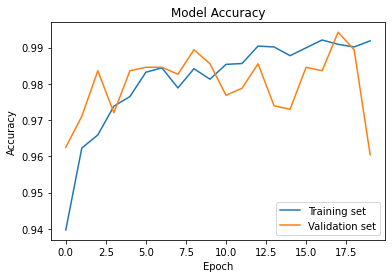

In [15]:
# Accuracy 
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='lower right')
plt.show()

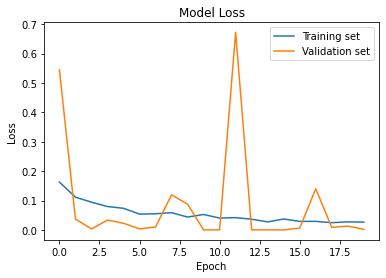

In [16]:
# Loss 
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training set', 'Validation set'], loc='upper right')
plt.show()

In [9]:
# kiểm thử mô hình
# đường dẫn đến thư mục test
Data_main =Path( '../X-ray/input/chest_xray/chest_xray')
test_dir = Data_main / 'test'

test_n = test_dir / 'NORMAL'
test_p = test_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_test = test_n.glob('*.jpeg')
pneumonia_test = test_p.glob('*.jpeg')

test_data_t = []
test_labels_t = []
 
# Normal cases
for img in normal_test:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    test_data_t.append(img)
    test_labels_t.append(label)
                      
# Pneumonia cases        
for img in pneumonia_test:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    test_data_t.append(img)
    test_labels_t.append(label)
    
# chuyển list thành mảng numpy
test_data = np.array(test_data_t)
test_labels = np.array(test_labels_t)
print(test_data.shape)
print(test_labels)

(624, 224, 224, 3)
[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [12]:
# Đánh giá mô hình với dữ liệu test
loss, accuracy = model_h8.evaluate(test_data, test_labels, batch_size = 8)
print("giá trị hàm mất mát trên tập test: ", loss)
print("độ chính xác trên tập test: ", accuracy)

624/624 [==============================] - 114s 183ms/step
giá trị hàm mất mát trên tập test:  0.4271566053248385
độ chính xác trên tập test:  0.9358974099159241


In [5]:
predict = model_h8.predict(test_data, batch_size = 8)
print(predict)

[[1.0000000e+00 1.5349265e-14]
 [9.9999487e-01 5.1115931e-06]
 [1.0000000e+00 3.2504605e-19]
 ...
 [6.6755368e-10 1.0000000e+00]
 [1.5453796e-09 1.0000000e+00]
 [1.0288890e-03 9.9897110e-01]]


In [22]:

print(np.unique(model_h8.predict(test_data)[:,1]))

[3.25046050e-19 1.94388317e-16 2.23195723e-16 3.35620579e-16
 1.07236055e-15 1.30636208e-15 4.76929567e-15 1.39568592e-14
 1.53492653e-14 2.08302342e-14 2.73315729e-14 2.84356821e-14
 7.74230940e-14 1.14059370e-13 1.92528163e-13 3.02607521e-13
 3.10113534e-13 5.81735831e-13 9.93143393e-13 1.56089692e-12
 1.63764781e-12 2.11833611e-12 2.27068451e-12 2.27684711e-12
 2.56702277e-12 3.68113222e-12 4.87433661e-12 6.14824988e-12
 8.33223768e-12 9.46479527e-12 1.38317153e-11 1.74652948e-11
 2.04938341e-11 4.17631867e-11 4.38827967e-11 6.36948549e-11
 6.46826065e-11 7.47169479e-11 9.14463436e-11 2.21834023e-10
 2.99923975e-10 3.17163129e-10 3.32437966e-10 4.56763655e-10
 4.70989747e-10 5.56152568e-10 6.29665098e-10 6.41726672e-10
 6.95889180e-10 7.43042794e-10 8.48531301e-10 8.66414884e-10
 1.01135089e-09 1.02823594e-09 1.05236286e-09 1.78116877e-09
 2.14506013e-09 2.59702326e-09 2.72148570e-09 7.04809944e-09
 7.34916128e-09 8.09722511e-09 8.81095641e-09 1.15126486e-08
 1.15690444e-08 1.222648

In [18]:
y_pred = model_h8.predict(test_data)[:,1]
print(y_pred)

[1.53492653e-14 5.11158805e-06 3.25046050e-19 3.12306952e-06
 2.36302640e-08 4.70989747e-10 1.02823594e-09 8.09722511e-09
 1.00922980e-05 3.79325343e-06 4.76929567e-15 1.50211586e-03
 3.35620579e-16 9.61376063e-05 7.55845685e-05 3.05914255e-05
 1.00000000e+00 1.78116877e-09 3.10113534e-13 1.30636208e-15
 1.52315246e-04 1.64620069e-08 2.41902359e-02 1.29447812e-06
 1.63764781e-12 6.03779085e-07 8.66414884e-10 2.08302342e-14
 2.56702277e-12 1.56089692e-12 1.14059370e-13 6.14824988e-12
 2.27517674e-07 8.33223768e-12 8.49865174e-08 1.15690444e-08
 3.68113222e-12 2.59914646e-06 8.81095641e-09 2.91333784e-08
 1.66159645e-01 2.84356821e-14 2.26330340e-05 2.99923975e-10
 1.13124106e-05 2.55344748e-01 4.36061881e-02 5.48864976e-02
 4.08809911e-03 5.73570469e-06 4.89890226e-05 9.61042588e-06
 6.28508508e-01 4.65623407e-06 4.56310227e-04 1.38317153e-11
 6.52261674e-02 2.47201910e-06 2.04129592e-05 4.80281486e-08
 7.47169479e-11 3.35337332e-04 5.30748032e-02 1.07236055e-15
 2.27068451e-12 4.874336

In [5]:
test_labels = (test_labels > test_labels.mean()).astype(int)
print(test_labels)
# test_data = (test_data > test_data.mean()).astype(int)
# orig_test_labels = np.argmax(test_labels, axis = 1)
# print(orig_test_labels)

[[1 0]
 [1 0]
 [1 0]
 ...
 [0 1]
 [0 1]
 [0 1]]


In [5]:
orig_test_labels = np.argmax(test_labels, axis = 1)
no_skill = len(orig_test_labels[orig_test_labels==1]) / len(orig_test_labels)
print(no_skill)
count = 0
for i in orig_test_labels:
    if i == 1:
     count+=1
print(count)

0.625
390


In [15]:
#find out best threshold for max fscore
from sklearn.metrics import f1_score
from numpy import arange
from numpy import argmax
orig_test_labels = np.argmax(test_labels, axis = 1)
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
 return (pos_probs >= threshold).astype('int')
# keep probabilities for the positive outcome only with [:,1]
y_pred = model_h8.predict(test_data)[:,1]
# thresholds = arange(0, 1, 0.001)
thresholds1 = []
for p in np.unique(model_h8.predict(test_data)[:,1]):
 thresholds1.append(p)
scores = [f1_score(orig_test_labels, to_labels(y_pred, t)) for t in thresholds1]
ix_max = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (thresholds1[ix_max], scores[ix_max]))

Threshold=0.842, F-Score=0.95890


Best Threshold=0.842263, F-Score=0.95890


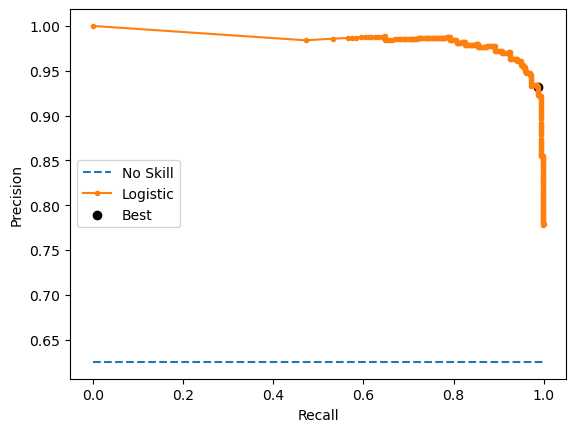

In [62]:
#find out best threshold for max fscore
from sklearn.metrics import precision_recall_curve
from numpy import argmax
from matplotlib import pyplot
# calculate pr-curve
y_pred = model_h8.predict(test_data)[:,1]
precision, recall, thresholds = precision_recall_curve(orig_test_labels, y_pred)
#convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.5f' % (thresholds[ix], fscore[ix]))
# plot the roc curve for the model
no_skill = len(orig_test_labels[orig_test_labels==1]) / len(orig_test_labels)
pyplot.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
pyplot.plot(recall, precision, marker='.', label='Logistic')
pyplot.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
# show the plot
pyplot.show()

In [10]:
from sklearn.metrics import accuracy_score
orig_test_labels = np.argmax(test_labels, axis = 1)
threshold = []
Accuracy = []
y_pred = model_h8.predict(test_data)[:,1] 
for p in np.unique(y_pred):
 threshold.append(p)
 y_predict = (y_pred >= p).astype('int')
 Accuracy.append(accuracy_score(orig_test_labels,y_predict))

In [11]:
print(len(threshold))
print(len(Accuracy))

369
369


Best Threshold=0.842263, Accuracy=0.947115


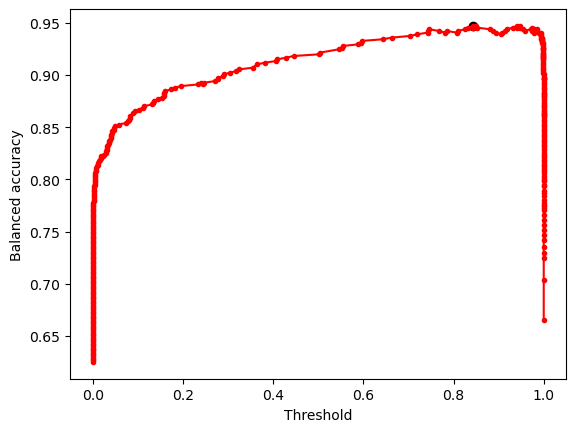

In [12]:
index_max = np.argmax(Accuracy)
print('Best Threshold=%f, Accuracy=%f' % (threshold[index_max], Accuracy[index_max]))
plt.plot(threshold,Accuracy, marker='.', color='red')
plt.scatter(threshold[index_max],Accuracy[index_max], marker='o', color='black', label='Best')
plt.xlabel("Threshold")
plt.ylabel("Balanced accuracy")
plt.show()

In [59]:
#do predict with best threshold respective to a maximum fscore
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
cm  = confusion_matrix(orig_test_labels, to_labels(y_pred, thresholds[ix]))
tn, fp, fn, tp = cm.ravel()
Precision = tp/(tp+fp)
print('Precision của mô hình trên tập test là {:.2f}'.format(Precision))
print('F-Score with best threshold: %f' % f1_score(orig_test_labels,to_labels(y_pred, thresholds[ix])))
print('Accuracy của mô hình trên tập test: %f' % accuracy_score(orig_test_labels,to_labels(y_pred, thresholds[ix])))

Precision của mô hình trên tập test là 0.93
F-Score with best threshold: 0.958904
Accuracy của mô hình trên tập test: 0.947115


[[206  28]
 [  5 385]]


<Figure size 640x480 with 0 Axes>

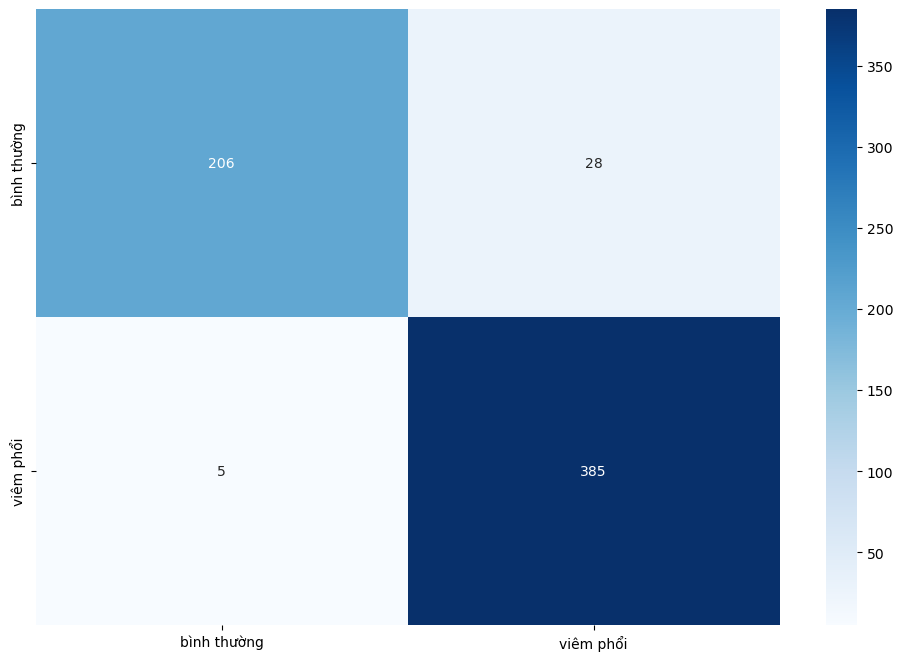

In [60]:
#do predict with best threshold respective to a maximum fscore
cm  = confusion_matrix(orig_test_labels, to_labels(y_pred, thresholds[ix]))
print(cm)
plt.figure()
df_cm = pd.DataFrame(cm, index = [i for i in ["bình thường", "viêm phổi"]],
                  columns = [i for i in ["bình thường", "viêm phổi"]])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
plt.show()

0
1.0
0.018378401
[[123 111]
 [  0 390]]


<Figure size 640x480 with 0 Axes>

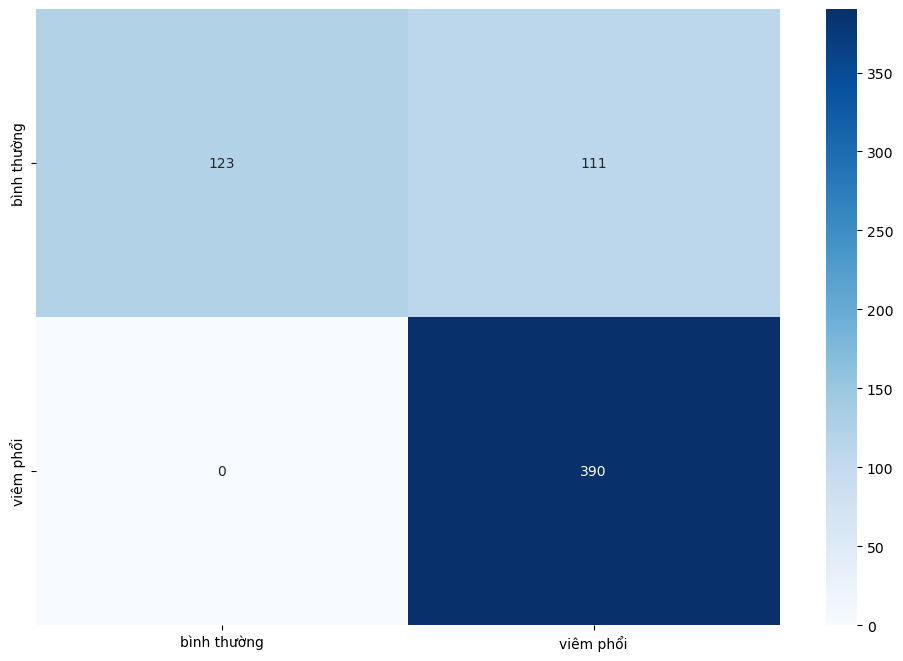

In [63]:
#do predict with maximum recall
index_max_recall = argmax(recall)
print(index_max_recall)
print(recall[index_max_recall])
print(thresholds[index_max_recall])
cm = confusion_matrix(orig_test_labels, to_labels(y_pred, thresholds[index_max_recall]))
print(cm)
plt.figure()
df_cm = pd.DataFrame(cm, index = [i for i in ["bình thường", "viêm phổi"]],
                  columns = [i for i in ["bình thường", "viêm phổi"]])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
plt.show()

In [19]:
predict = model_h8.predict(test_data, batch_size = 8)
#predict with default threshold = 0.5
test_predict = np.argmax(predict, axis = 1)
orig_test_labels = np.argmax(test_labels, axis = 1)
print(test_predict.shape)
print(orig_test_labels.shape)
print(test_predict)

(624,)
(624,)
[0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 1 0 1 1 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 1 1
 0 0 1 0 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 1 1 1 1 1 1 1 0 0 0 1 1 0 1 1 1 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 

[[186  48]
 [  2 388]]


<Figure size 640x480 with 0 Axes>

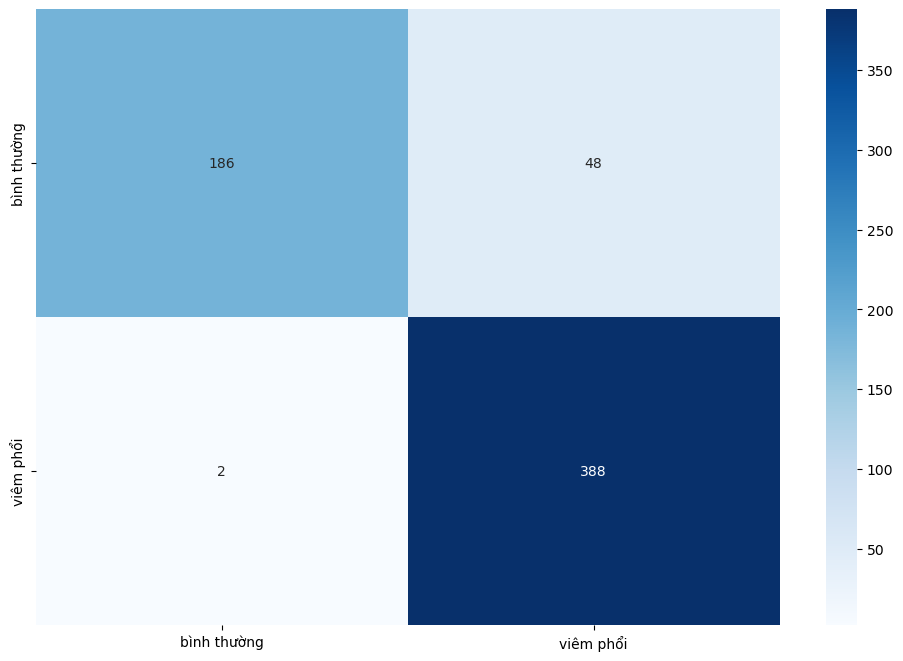

In [56]:
cm = confusion_matrix(orig_test_labels, test_predict)
print(cm)
plt.figure()
df_cm = pd.DataFrame(cm, index = [i for i in ["bình thường", "viêm phổi"]],
                  columns = [i for i in ["bình thường", "viêm phổi"]])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
plt.show()

In [58]:
from sklearn.metrics import accuracy_score
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = accuracy_score(orig_test_labels, test_predict)

print('Recall của mô hình trên tập test là {:.2f}'.format(recall))
print('Precision của mô hình trên tập test là {:.2f}'.format(precision))
print('Accuracy của mô hình trên tập test là %.2f' % accuracy)

Recall của mô hình trên tập test là 0.99
Precision của mô hình trên tập test là 0.89
Accuracy của mô hình trên tập test là 0.92


In [48]:
# đường dẫn đến thư mục val
val_dir = Data_main / 'val'

val_n = val_dir / 'NORMAL'
val_p = val_dir / 'PNEUMONIA'

# lấy danh sách tất cả hình ảnh 
normal_val = val_n.glob('*.jpeg')
pneumonia_val = val_p.glob('*.jpeg')

valid_data = []
valid_labels = []
 
# Normal cases
for img in normal_val:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(0, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
                      
# Pneumonia cases        
for img in pneumonia_val:
    img = cv2.imread(str(img))
    img = cv2.resize(img, (224,224))
    if img.shape[2] ==1:
        img = np.dstack([img, img, img])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.
    label = to_categorical(1, num_classes=2)
    valid_data.append(img)
    valid_labels.append(label)
    
# chuyển list thành mảng numpy, keras yêu cầu
valid_data = np.array(valid_data)
valid_labels = np.array(valid_labels)
print(valid_data.shape)

(16, 224, 224, 3)


In [69]:
#do predict with best threshold respective to a maximum fscore
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
orig_valid_labels = np.argmax(valid_labels, axis = 1)
y_pred_val = model_h8.predict(valid_data)[:,1]
precision_val, recall_val, thresholds_val = precision_recall_curve(orig_valid_labels, y_pred_val)
#convert to f score
fscore_val = (2 * precision_val * recall_val) / (precision_val + recall_val)
# locate the index of the largest f score
ix_val = argmax(fscore_val)
cm  = confusion_matrix(orig_valid_labels, to_labels(y_pred_val, thresholds_val[ix_val]))
tn, fp, fn, tp = cm.ravel()
Precision = tp/(tp+fp)
print('best threshold: %f' %thresholds_val[ix_val])
print('Precision của mô hình trên tập test là {:.2f}'.format(Precision))
print('F-Score with best threshold: %f' % f1_score(orig_valid_labels,to_labels(y_pred_val, thresholds_val[ix_val])))
print('Accuracy của mô hình trên tập test: %f' % accuracy_score(orig_valid_labels,to_labels(y_pred_val, thresholds_val[ix_val])))

best threshold: 0.930502
Precision của mô hình trên tập test là 1.00
F-Score with best threshold: 1.000000
Accuracy của mô hình trên tập test: 1.000000


[[8 0]
 [0 8]]


<Figure size 640x480 with 0 Axes>

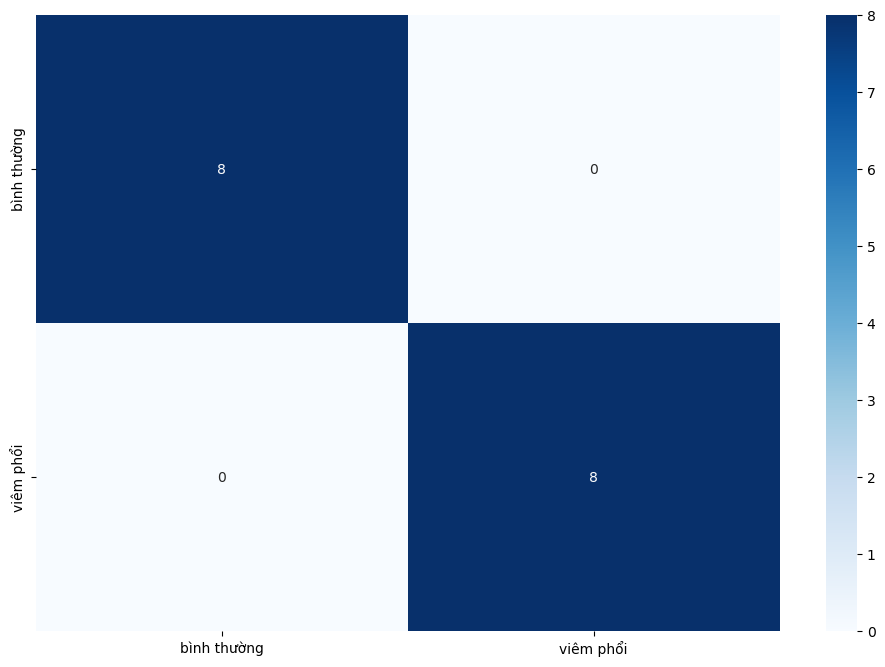

In [68]:
#do predict with best threshold respective to a maximum fscore 
print(cm)
plt.figure()
df_cm = pd.DataFrame(cm, index = [i for i in ["bình thường", "viêm phổi"]],
                  columns = [i for i in ["bình thường", "viêm phổi"]])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
plt.show()

In [15]:
# Đánh giá mô hình với dữ liệu val
loss, accuracy = model_h8.evaluate(valid_data, valid_labels, batch_size = 4)
print("giá trị hàm mất mát trên tập test: ", loss)
print("độ chính xác trên tập test: ", accuracy)

16/16 [==============================] - 3s 197ms/step
giá trị hàm mất mát trên tập test:  0.3610877610627483
độ chính xác trên tập test:  0.9375


In [49]:
predict = model_h8.predict(valid_data, batch_size = 4) #output probabilities
#do predict with default threshold = 0.5
valid_predict = np.argmax(predict, axis = 1)
orig_valid_labels = np.argmax(valid_labels, axis = 1)
print(valid_predict.shape)
print(orig_valid_labels.shape)
print(valid_predict)

(16,)
(16,)
[0 1 0 0 0 1 0 0 1 1 1 1 1 1 1 1]


[[6 2]
 [0 8]]


<Figure size 640x480 with 0 Axes>

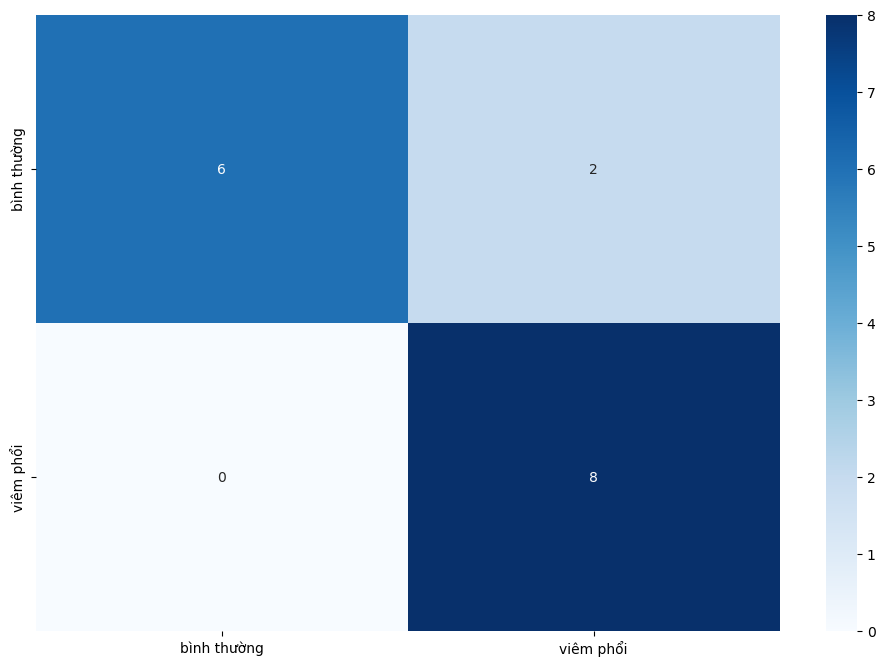

In [50]:
cm  = confusion_matrix(orig_valid_labels, valid_predict)
print(cm)
plt.figure()
df_cm = pd.DataFrame(cm, index = [i for i in ["bình thường", "viêm phổi"]],
                  columns = [i for i in ["bình thường", "viêm phổi"]])
plt.figure(figsize = (12,8))
sn.heatmap(df_cm, annot=True, fmt="d",cmap=plt.cm.Blues)
plt.show()

In [51]:
from sklearn.metrics import accuracy_score
tn, fp, fn, tp = cm.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)
accuracy = accuracy_score(orig_valid_labels, valid_predict)

print("Recall của mô hình trên tập test là {:.2f}".format(recall))
print("Precision của mô hình trên tập test là {:.2f}".format(precision))
print('Accuracy của mô hình trên tập test là %.2f' % accuracy)

Recall của mô hình trên tập test là 1.00
Precision của mô hình trên tập test là 0.80
Accuracy của mô hình trên tập test là 0.88


ảnh này bình thường


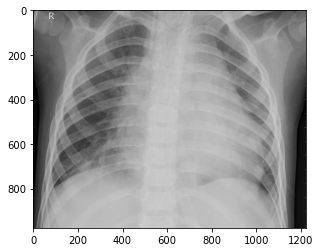

In [32]:
# thực hiện dự đoán thực tế của mô hình với ảnh lấy trong tập test gồm 624 ảnh gồm 2 loại bị bệnh và không bị bệnh
Y_pred = model.predict(test_data[392].reshape(1,224,224,3))
y = np.argmax(Y_pred)
if y==1:
    print('ảnh này bị viêm phổi')
else:
    print('ảnh này bình thường')
normal_test = test_n.glob('*.jpeg')
pneumonia_test = test_p.glob('*.jpeg')
b = []
for img in normal_test:
    img = cv2.imread(str(img))
    b.append(img)
for img in pneumonia_test:
    img = cv2.imread(str(img))
    b.append(img)
plt.imshow(b[392], cmap = 'gray')
plt.show()

390


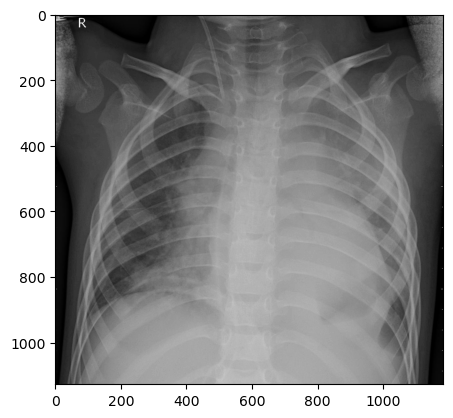

In [61]:
# thử hiển thị ảnh thứ 393 trong tập test tức ảnh thứ 159 trong thư mục bị bệnh (pneumonia)
#normal_test = test_n.glob('*.jpeg')
pneumonia_test = test_p.glob('*.jpeg')
f = []
for img in pneumonia_test:
    f.append(img)
print(len(f))
img = imread(f[159])
plt.imshow(img, cmap = 'gray')
plt.show()
# đúng là ảnh này bị viêm phổi vì nằm trong thư mục bị bệnh đã được bác sĩ phân loại trước